In [38]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

# Introduction
This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know.

In this article we are going to  explore the main differences between deterministic and probabilistic regression. In general, deterministic regression is useful when the relationship between the independent and dependent variables is well understood and relatively stable. On the other hand, probabilistic regression is more appropriate when there is uncertainty or variability in the data. As an exercise to support our claims, we are going to fit a probabilistic model to non-linear data using TensorFlow Probability.

We develop our models using TensorFlow and TensorFlow Probability. TensorFlow Probability is a Python library built on top of TensorFlow. We are going to start with the basic objects that we can find in TensorFlow Probability and understand how can we manipulate them. We will increase complexity incrementally over the following weeks and combine our probabilistic models with deep learning on modern hardware (e.g. GPU).

As usual, the code is available on my GitHub.

# Deterministic vs Probabilistic Regression
Deterministic regression is a type of regression analysis in which the relationship between the independent and dependent variables is known and fixed. In other words, if the same inputs are provided to a deterministic regression model, it will always produce the same output. This makes it a useful tool for predicting the value of a dependent variable given a set of known independent variables.

If we think about linear regression models, the Gauss-Markov theorem immediately comes to mind since it establishes the optimality of the ordinary least squares (OLS) estimator, under certain assumptions. In particular, the Gauss-Markov theorem states that the OLS estimator is the best linear unbiased estimator (BLUE), meaning that it has the smallest variance among all linear unbiased estimators. However, the Gauss-Markov theorem does not address the issue of uncertainty or belief in the estimates, which is a key aspect of the probabilistic approaches.

Probabilistic regression is a type of regression analysis in which the relationship between the independent and dependent variables is not known and may vary from one set of data to another. Instead of predicting a single value for the dependent variable, a probabilistic regression model predicts a probability distribution for the possible values of the dependent variable. This allows the model to account for uncertainty and variability in the data, and can provide more accurate predictions in some cases.

Probabilistic regression can be seen as a form of Bayesian statistics, in that it involves treating the unknown relationship between the independent and dependent variables as a random variable, and estimating its probability distribution based on the available data. In this way, probabilistic regression can be seen as a way of incorporating uncertainty and variability into regression analysis, in a way that is similar to Bayesian statistics. Recall that Bayesian statistics is a framework for statistical analysis in which all unknown quantities are treated as random variables, and their probability distributions are updated as new data is observed. This is in contrast to classical statistics, which typically assumes that unknown quantities are fixed, but unknown, parameters.

One way to think about the difference between the two approaches is to consider the trade-off between bias and variance in statistical estimates. Bias refers to the difference between the estimated value and the true value of a parameter, while variance refers to the spread or variability of the estimated values. By providing a distribution over the model parameters, rather than a single point estimate, probabilistic regression can help reduce bias in the estimates, which can improve the overall accuracy of the model. Additionally, probabilistic regression can provide a measure of uncertainty or confidence in the estimated values, which can be useful for making decisions or predictions based on the model. This can be particularly helpful when working with noisy or incomplete data, where the uncertainty in the estimates is higher.

A simple example could be a researcher that is studying the relationship between the amount of time that students spend studying for a test and their scores on the test. In this scenario, the researcher could use the OLS method to estimate the slope and intercept of the regression line, and use the Gauss-Markov theorem to justify the choice of this estimator.
However, as we stated before, the Gauss-Markov theorem does not address the issue of uncertainty or belief in the estimates. In the probabilistic world, the emphasis is on using probability to describe the uncertainty or belief in the model or parameter, rather than just the optimality of the estimator. This means that a Bayesian statistician might use a different approach to estimating the slope and intercept of the regression line, and might come to a different conclusion about the relationship between study time and test scores, based on the data and the prior belief in the values of the slope and intercept.

# Non-Linear Probabilistic Regression
Let's jump to an example to make these concepts easier to understand. We will not cover the full Bayesian approach which would entail the estimation of the epistemic uncertainty - the uncertainty of the model. We will study this type of uncertainty in a future article. Nevertheless, we will estimate another type of uncertainty - the aleatoric uncertainty. It can be defined as the uncertainty in the generative process  of the data. 

We can start by creating some data that follows a non-linear pattern. By generating this data synthetically, we have the advantage to know what was the exact generative process and, thus, we only need to find a way to get from the observations back to the generative process.

The data we'll be working with is artificially created from the following equation:
$$y_i = x_i^3+\frac{3}{15}(1+x_i)\epsilon_i$$

where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed.

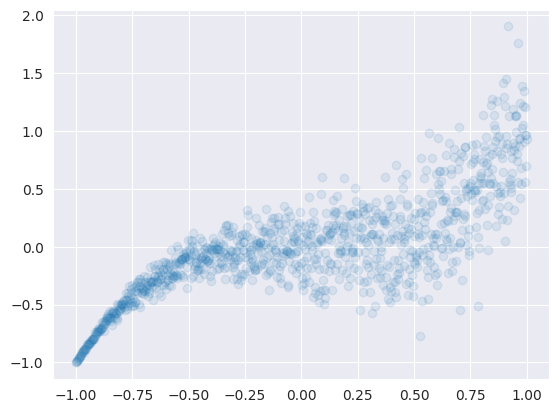

In [39]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + (3/15)*(1+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

As usual, we need to specify our loss function. In the probabilistic case, and as we already saw several examples in previous articles, we need to define the negative log-likelihood as our loss function.

In [40]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

As we saw in the previous article, a generic way to incorporate any distribution into a Deep Learning architecture in Keras is to use the `DistributionLambda` layer from TensorFlow Probability. Recall that the `DistributionLambda`  layer returns a distribution object. It is also the base class for several other probabilistic layers implemented in TensorFlow Probability and that we will use in future articles.

To build our model, we start by adding 2 dense layers. The first has 8 units and a sigmoid activation function. The second has 2 units and no activation function. The reason to not add one is because we want to parameterize our Gaussian distribution that follows with any real value. The Gaussian distribution is defined by the `DistributionLambd` layer. Notice that in this case, we are  using a lambda function to instantiate the `DistributionLambda` layer. The lambda function receives an input t, which is the output tensor of the previous Dense layer and returns a Gaussian distribution with mean and standard deviation defined by the tensor t. Remember that the scale of the distribution is the standard deviation, and this should be a positive value. As before, we pass the tensor component through the softplus function to respect this constraint.

Note that the real difference between a linear and a non-linear model is just the added Dense layer as the first layer of the model.

In [41]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
    # Dense(2),
    # tfpl.DistributionLambda(lambda t:tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:])))
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8)                 16        
                                                                 
 dense_19 (Dense)            (None, 2)                 18        
                                                                 
 independent_normal_5 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


We can check the output shape from our model to understand better what is happening. We get an empty event shape and a batch shape of (1000, 1). 1000 refers to the batch size, while the extra dimension does not really make a lot of sense in our problem statement. We want to represent a single random variable that is normally distributed.

In [42]:
y_model = model(x_train)
y_sample = y_model.sample()
y_model

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000] event_shape=[1] dtype=float32>

To simplify the implementation of our last layer and to make it more in line with what we expect to get as output shape, we can use a wrapper that TensorFlow Probability provides. By using the `IndependentNormal` layer we can build a similar distribution that we built with `DistributionLambda`.  At the same time, we can use a static method that outputs the number of  parameters that are required to the probabilistic layer and use it to  define the number of units in the previous Dense layer: `tfpl.IndependentNormal.params_size(event_shape=1)`.

In [43]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(2),
    tfpl.DistributionLambda(lambda t:tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:])))
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 16        
                                                                 
 dense_21 (Dense)            (None, 2)                 18        
                                                                 
 distribution_lambda_4 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


As we can see, the shape is now correctly specified as the extra dimension in the batch shape was moved to the event shape.

In [44]:
y_model = model(x_train)
y_sample = y_model.sample()
y_model

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000, 1] event_shape=[] dtype=float32>

Time to fit the model to our synthetically generated data.

In [45]:
# Train model

model.fit(x_train, y_train, epochs=500, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 0s 994us/step - loss: -0.4103


-0.41034603118896484

As expected, we were able to capture the aleatoric uncertainty of the generative process of the data. We can easily build confidence intervals using the learned standard deviation parameter. As a result, we are now able to generate new samples using the same process that we just learned from the data.

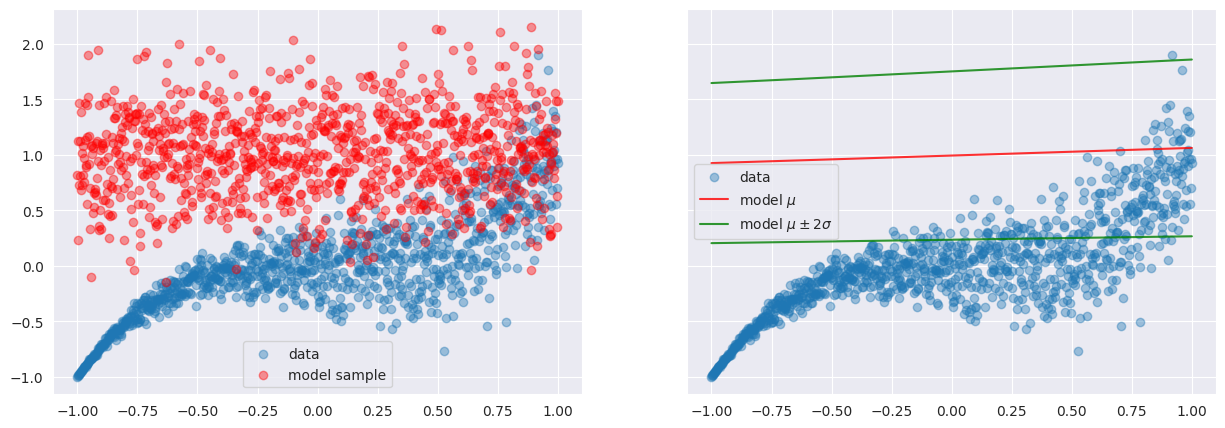

In [46]:
# Plot the data and a sample from the model

y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat -2 * y_sd
y_hat_p2sd = y_hat + 2*y_sd

fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

# Conclusion

This article explored the main differences between deterministic and probabilistic regression. We saw that in general, deterministic regression is useful when the relationship between the independent and dependent variables is well understood and relatively stable. On the other hand, probabilistic regression is more appropriate when there is uncertainty or variability in the data. As an exercise to support our claims, we then fitted a probabilistic model to non-linear data. By adding an extra dense layer with a activation function in the beginning of our model, we are able to learn non-linear patterns in the data. As before, our final layer is a probabilistic layer, which means that it outputs a distribution object. As a way to be more coherent with our problem statement, we extended our approach to use theIndependentNormal layer that we explored a few articles ago. It allows us to move batch dimensions to the event shape. By specifying our model with two additional variables defined in the new probabilistic layer, we were able to learn the mean and standard deviation of the Gaussian noise that was used to generate the artificial data. By using these parameters, we were also able to build confidence intervals but, more importantly, to generate new samples using the same process that we have learned from the data.

Next week, we will explore more the differences between a frequentist and a Bayesian approach. See you then!

# References and Materials

[1] - [Coursera: TensorFlow 2 for Deep Learning Specialization](https://www.coursera.org/specializations/tensorflow2-deeplearning)

[2] - [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

[3] - [TensorFlow Probability Guides and Tutorials](https://www.tensorflow.org/probability/overview)

[4] - [TensorFlow Probability Posts in TensorFlow Blog](https://blog.tensorflow.org/search?label=TensorFlow+Probability&max-results=20)